<h1 align="center">Recipe Recommendation System and Sentiment Analysis</h1>


This project aims to build a Recipe Recommendation System and conduct Sentiment Analysis on the dataset available from [Food.com](https://www.food.com), specifically the ["Recipes and Reviews" dataset hosted on Kaggle](https://www.kaggle.com/food-com-recipes-and-reviews). The project is divided into two distinct sections, each addressing a different aspect of user interaction and data utility:


1.    Sentiment Analysis: 

    The first goal is to analyze the sentiments expressed in the reviews submitted by users on Food.com. By classifying these sentiments as positive, negative, or neutral, the project seeks to gauge the overall consumer reception and emotional responses to recipes.

2.    Recipe Recommendation System:

    The second aim of this project is to develop a robust Recipe Recommendation System to enhance user experience on a culinary platform. The system utilizes two main approaches: Collaborative Filtering via Singular Value Decomposition (SVD) and content-based filtering using Word2Vec for ingredient-based similarities.


## Recipe Recommendation System

The system is designed to serve two main functions:

*    Recipe Recommendation using SVD combined with cosine similarity. The system recommends recipes based on user preferences gathered from a user-recipe rating matrix. This method capitalizes on the collaborative filtering technique, which leverages collective user ratings to make predictions.
  
*    Ingredient-based Recommendation for New Users: For users without prior ratings or interactions, the system employs a Word2Vec model to analyze recipes based on their ingredients. When a new user searches for a recipe, the system finds and recommends the top 10 recipes with similar ingredient profiles.

In [1]:
# Import required libraries
import random
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
# Set seed
random.seed(42)

In [2]:
# Load the data in dataframes for recipes and reviews
recipes_df = pd.read_csv('./data/recipes.csv')
reviews_df = pd.read_csv('./data/reviews.csv')

In [3]:
print(recipes_df.shape)
print(reviews_df.shape)

(522517, 28)
(1401982, 8)


In [4]:
# Check the content in recipe and review dataframe
recipes_df.iloc[0]

RecipeId                                                                     38
Name                                          Low-Fat Berry Blue Frozen Dessert
AuthorId                                                                   1533
AuthorName                                                               Dancer
CookTime                                                                  PT24H
PrepTime                                                                  PT45M
TotalTime                                                              PT24H45M
DatePublished                                              1999-08-09T21:46:00Z
Description                   Make and share this Low-Fat Berry Blue Frozen ...
Images                        c("https://img.sndimg.com/food/image/upload/w_...
RecipeCategory                                                  Frozen Desserts
Keywords                      c("Dessert", "Low Protein", "Low Cholesterol",...
RecipeIngredientQuantities              

In [5]:
reviews_df.iloc[0]

ReviewId                                                    2
RecipeId                                                  992
AuthorId                                                 2008
AuthorName                                          gayg msft
Rating                                                      5
Review           better than any you can get at a restaurant!
DateSubmitted                            2000-01-25T21:44:00Z
DateModified                             2000-01-25T21:44:00Z
Name: 0, dtype: object

### Feature Selection

In [6]:
# Select the features from recipe and review dataset
recipe_features = ['RecipeId', 'Name', 'RecipeIngredientParts']
review_features = ['AuthorId', 'RecipeId', 'Rating']

### Data Pre-processing

In [7]:
# Set the regex token for cleaning the features containing 'c(' and ')'
separator_regex = r'c\(|\)'

In [8]:
# Specify feature columns needed separator_regex removal
columns_to_clean = ['Images','RecipeIngredientParts']

# Clean the columns
for col in columns_to_clean:
    # Remove 'c(' at the beginning and ')' at the end of the string
    recipes_df[col] = recipes_df[col].str.replace(r'^c\(', '', regex=True)
    recipes_df[col] = recipes_df[col].str.replace(r'\)$', '', regex=True)


In [9]:
# Merging reviews and recipes features on column 'RecipeId'
recipe_reviews_df = pd.merge(reviews_df[review_features], recipes_df[recipe_features],  on='RecipeId', how='inner')

# Remove duplicates reviews based on reviewer and recipe
recipe_reviews_df = recipe_reviews_df.drop_duplicates(subset=['AuthorId', 'RecipeId'])

In [10]:
recipe_reviews_df.shape

(1401963, 5)

### EDA (Exploratory Data Analysis)

#### Distribution of Ratings

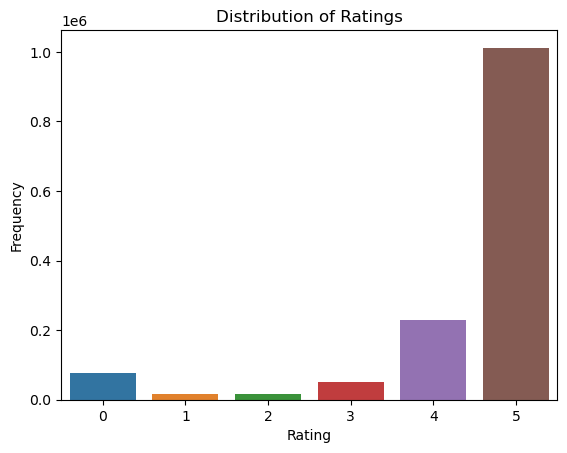

In [11]:
sns.countplot(x='Rating', data=recipe_reviews_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

A high number of high ratings indicate a tendency among users to rate only recipes they really like.

Plot demonstrates user engagement level for both casual and power users.

In [12]:
# Calculating descriptive statistics
desc_stats = recipe_reviews_df['Rating'].describe()
print(desc_stats)

# Calculate skewness
skewness = recipe_reviews_df['Rating'].skew()
print(f"Skewness: {skewness}")

count    1.401963e+06
mean     4.407949e+00
std      1.272013e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64
Skewness: -2.556723435253358


-2.9 skewness indicates that the distribution is negatively skewed. Also, shows the mean is less than the median, and the bulk of the data is concentrated to the right.

#### Number of Ratings per Recipe
Identify how frequently each recipe is rated, which can indicate recipe popularity.

C:\Users\bplse\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


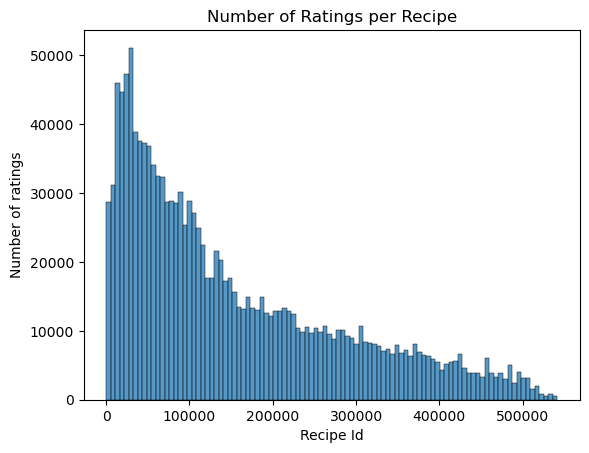

In [13]:
# Plot ratings count per recipe

sns.histplot(recipe_reviews_df['RecipeId'], bins=100, kde=False)
plt.title('Number of Ratings per Recipe')
plt.xlabel('Recipe Id')
plt.ylabel('Number of ratings')
plt.show()

Above plot shows some of the recipes with very few ratings indicating the problem of "sparsity" in the dataset. Sparse data can lead to challenges in accurately predicting user preferences and can skew the results of data-driven models. This we will handle by removing recipes that have below a certain threshold number of ratings to ensure that the data used in analysis and model training is robust.

Helper functions

In [14]:
# Helper function to print recipe names from recipe ids
def recipeIdToName(id_list):
    recipe_name_list = []    
    print('........................................')
    for index in id_list:       
        recipe_name =  recipes_df.loc[recipes_df['RecipeId'] == index]['Name'].iloc[0]
        ingredients = recipes_df.loc[recipes_df['RecipeId'] == index]['RecipeIngredientParts'].iloc[0] 
        recipe_name_list.append(recipe_name)
        print(recipe_name)
    return recipe_name_list

# Helper function to print recipe names and ingredints from recipe ids
def recipeIdToNameIngredient(id_list):   
    print('\n........................................')
    for index in id_list:       
        recipe_name =  recipes_df.loc[recipes_df['RecipeId'] == index]['Name'].iloc[0]
        ingredients = recipes_df.loc[recipes_df['RecipeId'] == index]['RecipeIngredientParts'].iloc[0]       
        print(recipe_name,' ingredients ---> \t\t\n\t', ingredients, )


### Methodologies 

#### Collaborative Filtering Using SVD and Cosine Similarity:   
   The objective of this approach is to recommend new recipes to a user based on the preferences of others with similar tastes. The user-recipe rating matrix is constructed from user interactions, where entries represent user ratings given to recipes. SVD model is applied to decompose the rating matrix, reducing dimensionality and uncovering latent factors that represent underlying patterns in user-recipe rating matrix. Cosine similarity scores are computed between users and recipes to identify  top 10 recipes to a user based on the highest similarity scores.

<h5 align="center"><u>Implementation</u></h5>

Split the dataset into training and testing and train the SVD model using Training dataset.

In [15]:
from surprise.model_selection import train_test_split, cross_validate
from surprise import Dataset, Reader, accuracy, SVD

# Define a reader with the rating_scale
reader = Reader(rating_scale=(1, 5))

# Load the dataset
data = Dataset.load_from_df(df=recipe_reviews_df[['AuthorId', 'RecipeId', 'Rating']],  reader=reader)

# Split the data into training (80%) and testing sets
trainset, testset = train_test_split(data, test_size=0.20, random_state=42)

# Create SVD model and fit the training set
svd_model = SVD()
svd_model.fit(trainset)

# Make predictions on the testset
predictions = svd_model.test(testset)


In [16]:
# Calculate RMSE
rmse = accuracy.rmse(predictions)

RMSE: 1.2275


An RMSE of 1.22 implies that on average, the predicted ratings deviate from the actual ratings by just over one rating point. For instance, if a recipe is actually rated 4 by a user, the model might predict a rating of approximately 2.78 or 5.22.

<h5 align="center"><u>Evaluate recommended recipes</u></h5>

To calculate precision and recall for the top K recommended recipes we need to first generate predictions for each user-recipe pair,
then sort these predictions to identify the top K recommendations for each user. After determining the top K recommendations,
compute precision and recall based on whether these recipes meet the criteria of relevance (e.g., actual ratings above a certain threshold).

In [17]:
# To evaluate the top k recommnedations we used precision and recall metrics.
# precision = relevant and recommended from top k / recommended based on estimated rating >= threshold
# accuracy = relevant and recommended from top k / all relevant from test set true rating >= threshold 
# Function to calculate Precision and Recall for top k recipe for each user

from collections import defaultdict

# predictions - Prediction made by model on test set. It includes user, estimated rating and true rating
# k = Number of recommendations
# threshold = threshold for relevant rating

def top_recommendations_precision_recall(predictions, k=10, threshold=3):

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_rating, estimated_rating, _ in predictions:
        user_est_true[uid].append((estimated_rating, true_rating))

    precisions = dict()
    recalls = dict()

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant recipes are all the recipes whose true rating >= thresold
        n_relevant = sum((true_rating >= threshold) for (_, true_rating) in user_ratings)

        # Number of recommended recipes in top k recipes whose estimated rating >= thresold
        n_recommended_k = sum((estimated_rating >= threshold) for (estimated_rating, _) in user_ratings[:k])

        # Number of relevant and recommended recipes in top k (true positive)
        n_rel_and_rec_k = sum(((true_rating >= threshold) and (estimated_rating >= threshold))
                              for (estimated_rating, true_rating) in user_ratings[:k])

        # Precision: Proportion of recommended recipes that are relevant
        precisions[uid] = n_rel_and_rec_k / n_recommended_k if n_recommended_k != 0 else 1

        # Recall: Proportion of relevant recipes that are recommended
        recalls[uid] = n_rel_and_rec_k / n_relevant if n_relevant != 0 else 1
        
    return precisions, recalls

In [18]:
# Calculate precision and recall for top 10 recommendations
recommend_top_k=10
precisions, recalls = top_recommendations_precision_recall(predictions, recommend_top_k, threshold=3)

# Calculate average precision and recall
avg_precision = sum(prec for prec in precisions.values()) / len(precisions)
avg_recall = sum(rec for rec in recalls.values()) / len(recalls)

print(f'Average Precision for top {recommend_top_k} recommendations: {avg_precision:.2f}')
print(f'Average Recall for top {recommend_top_k} recommendations: {avg_recall:.2f}')

Average Precision for top 10 recommendations: 0.83
Average Recall for top 10 recommendations: 0.97


Precision measures the proportion of recommended recipes (in the top 10) that are relevant to the user.

Precision (83%) means that, on average, 83% of the recipes recommended in the top 10 are relevant or were rated above the threshold (in this case, a rating of 3 or higher). Essentially, it's an indicator of how trustworthy the recommendations are; higher precision suggests that fewer irrelevant recipes are being recommended.
Recall measures the ability of the model to find all the relevant recipes within the top recommendations.

Recall (97%). This indicates that, on average, the system is able to recommend 97% of recipes that are relevant (rated above the threshold) within the top 10 recipes it suggests to a user. High recall indicates that the system is effective at not missing recipes that should be recommended.
These metrics suggest that the system is reliable in both identifying relevant recipes and ensuring that the recommendations it makes are likely to be appreciated, with potential for minimal adjustments.



<h5 align="center"><u>Test SVD Recommendations</u></h5>

Testcase #1: Recommned the recipes to existing user (id = 13273)

In [19]:
# Set a user = 13273 to test a specific user's recommendations. 
user = 13273

In [20]:
# Recommending recipes from original dataset
# Get the list of all recipes
all_recipes =  recipe_reviews_df['RecipeId'].unique()

# Get the recipes that user has already rated (we don't want to recommend the same)
rated_recipes =  recipe_reviews_df[ recipe_reviews_df['AuthorId'] == user]['RecipeId'].unique()

# Predict ratings for all recipes that user hasn't rated yet
predictions = []
for recipe in all_recipes:
    if recipe not in rated_recipes:
        # Predict the rating user_id might give to recipe
        predicted_rating = svd_model.predict(user,recipe).est
        predictions.append((recipe, predicted_rating))

# Sort the predictions by estimated rating in descending order
predictions.sort(key=lambda x: x[1], reverse=True)

# Get the top 10 recommended recipes
top_k_recommended_recipes = predictions[:recommend_top_k]
print(f"Top {recommend_top_k} recommended recipes for user_id:", top_k_recommended_recipes)

Top 10 recommended recipes for user_id: [(19724, 4.979998418481897), (31128, 4.945106623684756), (72605, 4.852367895455687), (128439, 4.844159300424179), (14499, 4.832146229044514), (29939, 4.831831520630815), (47444, 4.827795885373801), (99476, 4.826627262830035), (172232, 4.823394001002593), (72356, 4.822820864417534)]


In [21]:
recipe_ids = [item[0] for item in top_k_recommended_recipes]
print(f"Top {recommend_top_k} recommended recipes for user: {user}\n")
recipeIdToName(recipe_ids)

Top 10 recommended recipes for user: 13273

........................................
Adam's Ribs
Yummy Crunchy Apple Pie
Coffee House Cookies (Pampered Chef)
Green Chili Breakfast Casserole
Bacardi Rum Cake
Amish Apple Crisp
Bacon and Lettuce Stuffed Cherry Tomatoes
The Best Easy Beef and Broccoli Stir-Fry
Ground Beef Enchilada Casserole
Whipped Cream


["Adam's Ribs",
 'Yummy Crunchy Apple Pie',
 'Coffee House Cookies (Pampered Chef)',
 'Green Chili Breakfast Casserole',
 'Bacardi Rum Cake',
 'Amish Apple Crisp',
 'Bacon and Lettuce Stuffed Cherry Tomatoes',
 'The Best Easy Beef and Broccoli Stir-Fry',
 'Ground Beef Enchilada Casserole',
 'Whipped Cream']

#### Content-based filtering using Word2Vec for New Users:
   
Content-based filtering focuses on the ingredient in the recipes rather than user preference. We use a Word2Vec model to enhance our recipe recommendations based on ingredient similarity. A Word2Vec model is trained on the corpus of recipe ingredients to generate vector representations of each ingredient. When a new user queries a recipe, the ingredients are converted into their vector form using the trained Word2Vec model.  The cosine similarity between the queried recipe’s ingredient vector and all other recipe vectors in the dataset is calculated.Recipes with the highest similarity scores are selected and recommended to the user, focusing on matching ingredient profiles.

This approach is particularly useful for first-time searches where user history might not be available. It allows the system to make intelligent recommendations based on the content of the recipe itself, ensuring that every user, regardless of their history with the platform, can receive relevant suggestions. 

<h5 align="center"><u>Implementation</u></h5>

In [22]:
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [23]:
# Preprocess ingredients: split by comma and remove extra spaces - needed for Word2Vec
# Apply transformations in a single line using lambda
recipe_reviews_df['RecipeIngredientParts'] =  recipe_reviews_df['RecipeIngredientParts'].apply(lambda x: sorted([item.strip('"') for item in re.split(r'\s*,\s*', x)], key=str.lower))


In [24]:
# Remove rows where 'RecipeIngredientParts' list is empty
recipe_reviews_df =  recipe_reviews_df[recipe_reviews_df['RecipeIngredientParts'].apply(len) > 0]

# print( recipe_reviews_df.shape)

In [25]:
# Merge the recipe name and recipe increadient features to create more meaningful feature for incredient and name based feature

for i in range(len(recipe_reviews_df['Name'])):    
    recipe_reviews_df['RecipeIngredientParts'][i].append(recipe_reviews_df['Name'][i]) 


In [26]:
# recipe_reviews_df['RecipeIngredientParts'].iloc[0]

In [27]:
# Train a Word2Vec model for the recipe ingredients

model = Word2Vec(sentences=recipe_reviews_df['RecipeIngredientParts'], vector_size=300, window=20, seed = 42, min_count=1, workers=4)

In [28]:
# Dictionary of all recipes
all_recipes = recipe_reviews_df.set_index('RecipeId')['RecipeIngredientParts'].to_dict()

<h5 align="center"><u>Visual evaluation</u></h5>

In [29]:
#Testcase- UI to select the recipe from Menu. Simulating the recipe searched vy user.
# Recipe option are provided in the menu. 
# User Input = recipe id

# Define the dictionary with recipe ids as keys and names as values
recipe_id_name = {
    54: 'Carrot Cake',
    159: 'Chicken Curry',
    280: 'Spanish Potato Omelet',
    319: 'Fish Chowder',
    10899: 'Creamy Pesto Pasta Italiana' 
    }

# Function to select input from the user
def get_recipe_recommendation_testcase(): 
    try:
        # Ask the user to choose recipe id
        print("\n..............\nMenu\n..............\n")
        print("\nrecipe_id \t recipe name")
        for item in recipe_id_name.items():
            print(f"{item[0]} \t\t {item[1]}")
        user_input = int(input(f"\nChoose a recipe number from above options:\n\n "))
        # Check if the number is a valid key in the dictionary
        if user_input in recipe_id_name:
            return user_input
        else:
            print("Invalid recipe, please choose a valid number from the list.")
    except ValueError:
        print("Invalid input; please enter a numeric value.")

In [30]:
#  User select the recipe from this menu
recipe = get_recipe_recommendation_testcase()


..............
Menu
..............


recipe_id 	 recipe name
54 		 Carrot Cake
159 		 Chicken Curry
280 		 Spanish Potato Omelet
319 		 Fish Chowder
10899 		 Creamy Pesto Pasta Italiana



Choose a recipe number from above options:

  159


In [31]:
# Regular expression to find URLs
url_pattern = r'https?://[^\s]+"'
image_list = recipes_df[recipes_df['RecipeId'] == recipe]['Images']
# Convert the entire Series to one single string
image_string = ' '.join(image_list)
# Find all matches
urls = re.findall(url_pattern, image_string)
# Remove the trailing double quote from each URL and print them
#print(urls[0][:-1])

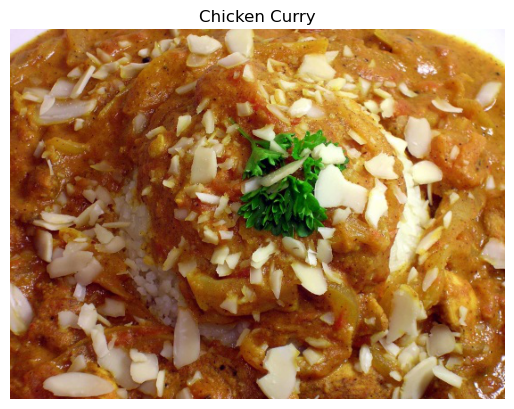

In [32]:
if urls != "":
    # Show image 
    from PIL import Image
    import requests
    from io import BytesIO
    
    # URL of the image
    image_url =urls[0][:-1]
    
    # Use requests to fetch the image from the internet
    response = requests.get(image_url)
    
    # Open the image using PIL
    img = Image.open(BytesIO(response.content))
    
    # Plotting the image using matplotlib
    plt.title(f'{recipe_id_name[recipe]}')
    plt.imshow(img)
    plt.axis('off')  # Hide the axis
    plt.show()



In [33]:
# Convert target recipe into a vector
target_recipe_Id = recipe  # 4684

# Target recipe is first recipe of matching id list
target_recipe_name =recipe_reviews_df[recipe_reviews_df['RecipeId'] == target_recipe_Id]['Name'].unique()

In [34]:
print(f'I am searching for: {target_recipe_name}')

I am searching for: ['Chicken Curry']


In [35]:
# target recipe
target_recipe_ingredients = recipe_reviews_df[recipe_reviews_df['RecipeId'] == target_recipe_Id]['RecipeIngredientParts'].iloc[0]
print(f'{target_recipe_name} has these ingredients: {target_recipe_ingredients}')

['Chicken Curry'] has these ingredients: ['basmati rice', 'bay leaf', 'black pepper', 'boneless skinless chicken breasts', 'butter', 'cardamom pods', 'cashews', 'cinnamon sticks', 'clove', 'cumin seeds', 'fresh cilantro', 'fresh ginger', 'garlic', 'ginger', 'golden raisin', 'mango chutney', 'onions', 'plain yogurt', 'red pepper flakes', 'salt', 'turmeric', 'whole canned tomatoes', 'Chicken Curry']


Evaluate Word2Vec embedding 

To evaluate the embedding ingredients and evaluating the similarity between them we are using Cosine Similarity approach. It measures the cosine of the angle between two recipe to indicate how similar they are in terms of direction in the vector space. Higher cosine values (close to 1) indicate greater similarity. 


In [36]:
# Based on target recipe find out what are the other recipes we can recommned to the user.

# Evaluate Word2Vec embedding using cosine similarity between target recipe and recommended recipes

# Recommend recipes based on cosine similarity of ingredient vectors

# Get the recipe ingredients vector from model and Sum then to create a single target vector
target_vec = sum([model.wv[ing] for ing in target_recipe_ingredients if ing in model.wv])

# Calculate similarities with other recipes
similarities = {}   
for idx, ingredients in all_recipes.items():   
    # For each recipe- get the recipe ingredients vector from model and Sum then to create a single recipe vector
    recipe_vec = sum([model.wv[ing] for ing in ingredients if ing in model.wv])
    # Calculate the similarity between target vector and recipe vector.
    sim = cosine_similarity([target_vec], [recipe_vec])[0][0]
    similarities[idx] = sim
    
# Sort recipes by similarity score and create dictionary of top recommended recipe  and its similarity with target recipe
recommended_recipe = sorted(similarities.items(), key=lambda item: item[1], reverse=True)[:recommend_top_k+1]


In [40]:
# Get recipe names from ids
print(f"Show me top {recommend_top_k} recipes like : {target_recipe_name} --> {target_recipe_ingredients[0:-1]}")
# Create empty list to hold recipe names
recommended_recipe_names = []
recipe_similarities = []

i = 1
for key, value in recommended_recipe:    
    if target_recipe_Id != key:
        print(f'#{i}')
        recommended_recipe_names.append(recipeIdToName([key])[0])
        recipe_similarities.append(value)
        print(f'\t Similarity: = {value*100:0.2f} %')
        recipeIdToNameIngredient([key])
        i = i+1
    


Show me top 10 recipes like : ['Chicken Curry'] --> ['basmati rice', 'bay leaf', 'black pepper', 'boneless skinless chicken breasts', 'butter', 'cardamom pods', 'cashews', 'cinnamon sticks', 'clove', 'cumin seeds', 'fresh cilantro', 'fresh ginger', 'garlic', 'ginger', 'golden raisin', 'mango chutney', 'onions', 'plain yogurt', 'red pepper flakes', 'salt', 'turmeric', 'whole canned tomatoes']
#1
........................................
Lamb Biryani
	 Similarity: = 94.58 %

........................................
Lamb Biryani  ingredients ---> 		
	 "plain yogurt", "garlic cloves", "cayenne", "ground cumin", "black pepper", "salt", "boneless lamb", "butter", "onion", "ground coriander", "turmeric", "cloves", "cinnamon stick", "basmati rice", "water", "raisins", "cashews"
#2
........................................
Spicy Indian-Style Skillet Chicken Biriyani
	 Similarity: = 94.15 %

........................................
Spicy Indian-Style Skillet Chicken Biriyani  ingredients ---> 		
	

<class 'str'> 10


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Lamb Biryani'),
  Text(1, 0, 'Spicy Indian-Style Skillet Chicken Biriyani'),
  Text(2, 0, 'Mild or Hot All in One Oven Curry'),
  Text(3, 0, 'Chickpea Curry With Yogurt'),
  Text(4, 0, 'Chicken Biryani'),
  Text(5, 0, 'chicken curry'),
  Text(6, 0, 'Kalya E Khaas (Traditional South African Chicken Curry)'),
  Text(7, 0, 'Kofta Curry'),
  Text(8, 0, 'Lamb and Tomato Curry'),
  Text(9, 0, "Bebe's Chicken Curry")])

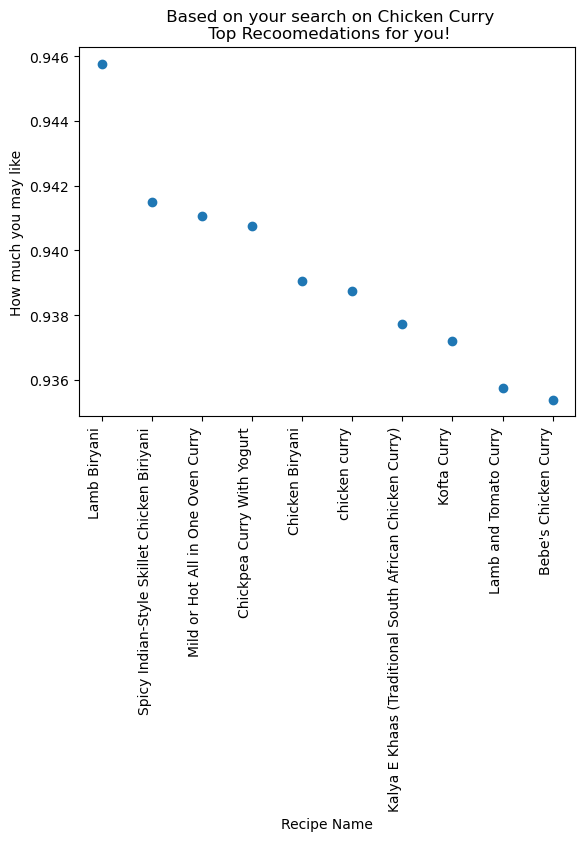

In [38]:
print(type(recommended_recipe_names[0]), len(recipe_similarities))
plt.scatter(recommended_recipe_names, recipe_similarities)
plt.title(f" Based on your search on {target_recipe_name[0]}\n Top Recoomedations for you!")
plt.xlabel("Recipe Name")
plt.ylabel("How much you may like")
plt.xticks(rotation=90, ha='right')

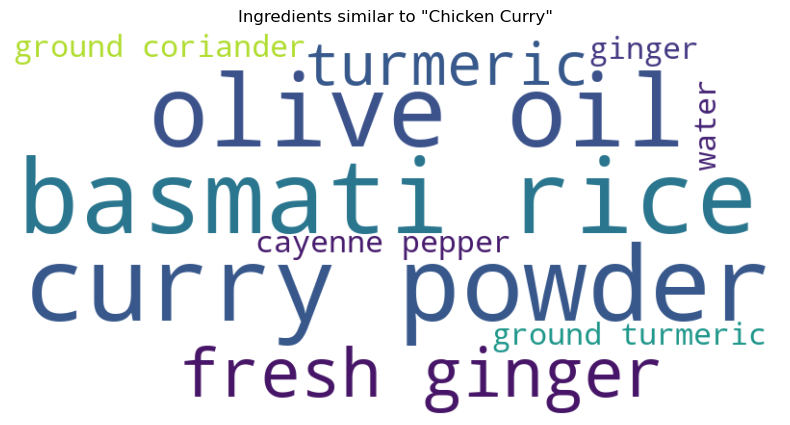

In [39]:
# Visualize the target recipe's ingredient frequency in the trained model

from wordcloud import WordCloud
# Calculate the centroid vector
centroid_vector = np.mean([model.wv[word] for word in target_recipe_ingredients if word in model.wv], axis=0)
# Find words similar to the centroid
similar_words = model.wv.similar_by_vector(centroid_vector, topn=10)
similar_words_dict = {word: float(similarity) for word, similarity in similar_words}

# Create a WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(similar_words_dict)

# Display the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Ingredients similar to "{}"'.format(" & ".join(target_recipe_name)))
plt.show()

### Conclusion

The implemented system effectively combines **collaborative filtering** and **content-based approaches** to cater to both existing and new users. While the collaborative filtering model provides personalized recommendations based on user history, the content-based model driven by Word2Vec offers a viable solution for first-time users by focusing on ingredient similarity.

The project demonstrates the feasibility and effectiveness of using advanced machine learning techniques like SVD and Word2Vec for developing a sophisticated recipe recommendation system. The positive outcomes from this project not only showcase its current capabilities but also highlight the potential for future improvements and innovations in the culinary recommendation domain.


### Future Enhancements

Future enhancements involve hybrid model development by combining collaborative filtering and content-based models into a hybrid system to leverage the strengths of both approaches.